$$
  -\Delta u(x,y) \;=\; f(x,y),
  \qquad (x,y)\in[a,a+L_x]\times[b,b+L_y],
$$
$$
a=0,\quad b=1/2,\quad Lx=2,\quad Ly=5/2
$$
$$
  f(x,y) = 2\pi^2\,\sin(\pi x)\cos(\pi y).
$$
$$
  u(a,y) = u(a+L_x,y) = u(x,b+L_y) = 0,
$$
$$
  \frac{\partial u}{\partial n}(x,y) = -\frac{\partial u}{\partial y}(x,b) = 0,
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# =============
# DEFINICION DEL MODELO

def gradients(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
a, b, Lx, Ly = 0, 1/2, 2, 5/2
N_STEPS = 2500                     # iteraciones de entrenamiento
N_COLLOC = 25000                   # puntos collocation para PDE
N_BC = 25000                       # puntos para condiciones de frontera e iniciales

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para approximar Psi(x,y,t)
class POISSON(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()]
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)
    
# class POISSON(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(2, layers[0]),
#             nn.ReLU(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.ReLU()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# class POISSON(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(2, layers[0]),
#             nn.Tanh(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = POISSON([50,50,50,50,50,50,50,50]).to(device)
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                milestones=[2500, 5000, 7500, 10000, 20000], gamma=0.25)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [3]:
# Parametros
EXTRA_EPOCHS = 0
lambda_D     = 100
lambda_N     = 100
# lambda_D     = 1
# lambda_N     = 1
model_path   = 'models/poisson/lambdas/poisson'
os.makedirs(model_path, exist_ok=True)

# Funciones exactas
def u_exact(x, y):
    return (torch.sin(torch.pi*x) * torch.sin(torch.pi*y))

def f_source(x, y):
    return (2 * (torch.pi)**2 * torch.sin(torch.pi*x) * torch.sin(torch.pi*y))

def q_S(x):
    return torch.sin(x*0) # funcion 0 tensorizada

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        mlp.train()
        loss_total = 0.0

        # Residuo PDE
        xy_pde = torch.rand(N_COLLOC, 2, device=device)
        xy_pde[:,0] = a + xy_pde[:,0] * Lx
        xy_pde[:,1] = b + xy_pde[:,1] * Ly
        xy_pde.requires_grad_(True)

        u_pred = mlp(xy_pde).squeeze()
        grads = gradients(u_pred, xy_pde)
        u_x, u_y = grads[:,0], grads[:,1]
        u_xx = gradients(u_x, xy_pde)[:,0]
        u_yy = gradients(u_y, xy_pde)[:,1]
        lap_u = u_xx + u_yy

        f_val = f_source(xy_pde[:,0], xy_pde[:,1]).to(device)
        loss_pde = mse(-lap_u - f_val, torch.zeros_like(lap_u))

        # Dirichlet en x=a y=b+Ly x=a+Lx
        xb1_D = torch.zeros(N_BC,1,device=device) + a
        yb1_D = b + torch.rand(N_BC,1,device=device)*Ly
        pts_D1 = torch.cat([xb1_D, yb1_D], dim=1)

        xb2_D = a + torch.rand(N_BC,1,device=device)*Lx
        yb2_D = torch.zeros(N_BC,1,device=device) + (b+Ly)
        pts_D2 = torch.cat([xb2_D, yb2_D], dim=1)

        xb3_D = torch.zeros(N_BC,1,device=device) + a + Lx
        yb3_D = b + torch.rand(N_BC,1,device=device)*Ly
        pts_D3 = torch.cat([xb3_D, yb3_D], dim=1)

        u_D1 = mlp(pts_D1).squeeze()
        u_D2 = mlp(pts_D2).squeeze()
        u_D3 = mlp(pts_D3).squeeze()
        uE1 = u_exact(pts_D1[:,0], pts_D1[:,1]).to(device)
        uE2 = u_exact(pts_D2[:,0], pts_D2[:,1]).to(device)
        uE3 = u_exact(pts_D3[:,0], pts_D3[:,1]).to(device)
        loss_D = lambda_D*(mse(u_D1, uE1) + mse(u_D2, uE2) + mse(u_D3, uE3))

        # Neumann en y=b
        xb_N = a + torch.rand(N_BC,1,device=device)*Lx
        yb_N = torch.zeros(N_BC,1,device=device) + b
        pts_N = torch.cat([xb_N, yb_N], dim=1)

        pts_N.requires_grad_(True)
        uN = mlp(pts_N).squeeze()
        uy_N = gradients(uN, pts_N)[:,1]
        qS_val = q_S(pts_N[:,0]).to(device)
        loss_N = mse(uy_N, qS_val)

        loss_N = lambda_N*loss_N

        # Optimizacion
        loss = loss_pde + loss_D + loss_N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        # Mostrar metricas en la barra
        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "D": f"{loss_D.item():.2e}",
            "N":  f"{loss_N.item():.2e}"
        })

    # Promedio de loss de la epoch
    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e} — lr: {optimizer.param_groups[0]['lr']}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_D': loss_D/lambda_D,
        'loss_N': loss_N/lambda_N
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

Cargado checkpoint de la época 10.
Entrenamiento completado.


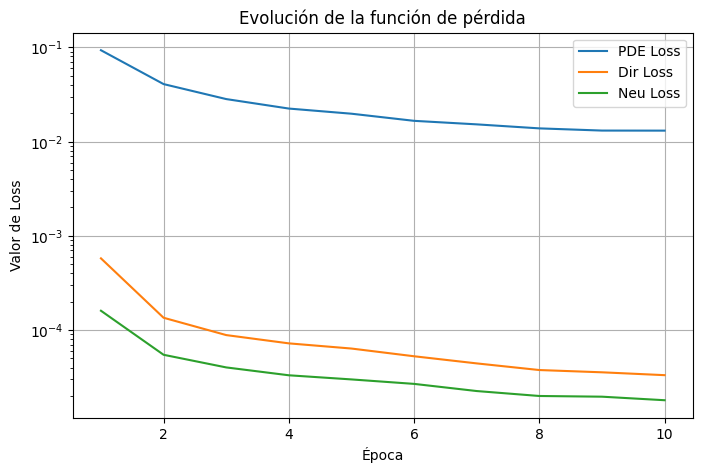

In [4]:
# =============
# REPRESENTACION DE LA EVOLUCION DEL ERROR

# Definir ruta y buscar archivos de checkpoint
model_path   = 'models/poisson/lambdas/poisson'
checkpoint_pattern = f"{model_path}_*.pth"
checkpoint_files = sorted(glob.glob(checkpoint_pattern))

# Preparar listas para almacenar datos
epochs    = []
loss_pde  = []
loss_ic   = []
loss_bc   = []

# Recorrer cada archivo y extraer la información
device = 'cpu'
for ckpt_file in checkpoint_files:
    ckpt = torch.load(ckpt_file, map_location=device)
    epoch_num = ckpt['epoch'] - 1
    epochs.append(epoch_num)
    loss_pde.append(ckpt['loss_pde'].item())
    loss_ic.append(ckpt['loss_D'].item())
    loss_bc.append(ckpt['loss_N'].item())

# Graficar las curvas de perdida
plt.figure(figsize=(8, 5))
plt.yscale('log')
plt.plot(epochs, loss_pde, label='PDE Loss')
plt.plot(epochs, loss_ic,  label='Dir Loss')
plt.plot(epochs, loss_bc,  label='Neu Loss')
plt.xlabel('Época')
plt.ylabel('Valor de Loss')
plt.title('Evolución de la función de pérdida')
plt.legend()
plt.grid(True)
plt.show()

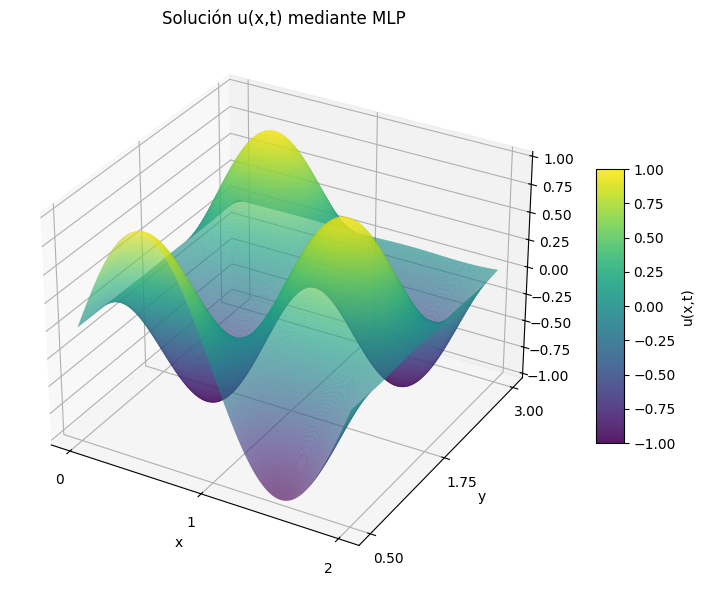

In [5]:
# =============
# REPRESENTACION DE LA SOLUCION MLP

# Parametros
N=2000
a, b, Lx, Ly = 0, 1/2, 2, 5/2

mlp.eval()
mlp.cpu()

# Generacion de la malla en [a,a+Lx]×[b,b+Ly]
x = np.linspace(a, a+Lx, N)
y = np.linspace(b, b+Ly, N)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.ravel(), Y.ravel()], axis=1)
inp = torch.from_numpy(XY).float().requires_grad_(True)

# Predicción de u aproximado
with torch.no_grad():
    u_pred = mlp(inp).squeeze().cpu().numpy().reshape(N, N)

# Grafica 3D de la superficie
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xticks = [a, a + Lx/2, a + Lx]
yticks = [b, b + Ly/2, b + Ly]

surf = ax.plot_surface(
    X, Y, u_pred,
    rstride=3, cstride=3,
    cmap='viridis', edgecolor='none', alpha=0.9
)

ax.set_title('Solución u(x,t) mediante MLP')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(xticks)
ax.set_yticks(yticks)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='u(x,t)')

plt.tight_layout()
plt.show()

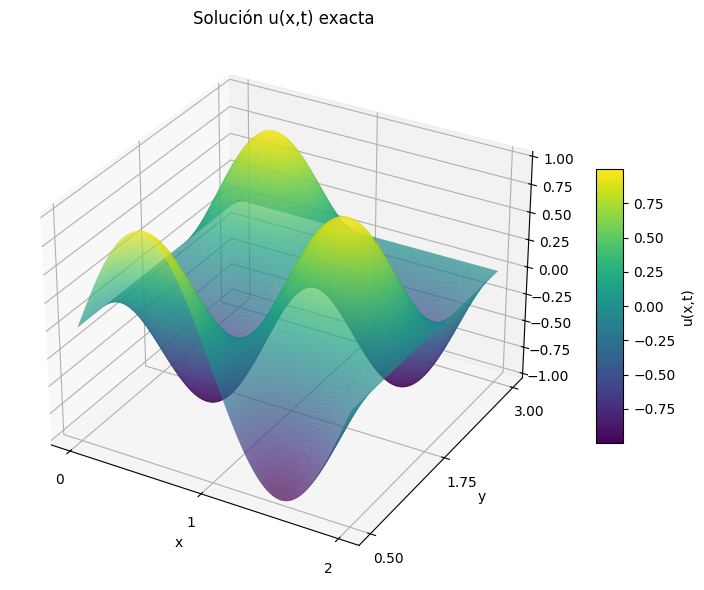

In [6]:
# =============
# REPRESENTACION DE LA SOLUCION EXACTA

# Parametros del dominio y malla
a, b, Lx, Ly = 0, 1/2, 2, 5/2
N = 2000
x = np.linspace(a, a + Lx, N + 2)
y = np.linspace(b, b + Ly, N + 2)
X, Y = np.meshgrid(x, y, indexing='ij')

# Funcion exacta
def uE(x, y):
    return np.sin(torch.pi * x) * np.sin(torch.pi * y)

# Preparacion de ticks
xticks = [a, a + Lx/2, a + Lx]
yticks = [b, b + Ly/2, b + Ly]

# Visualizacion 3D sin subplots
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(
    X, Y, uE(X, Y),
    cmap='viridis', rstride=3, cstride=3
)

ax.set_title('Solución u(x,t) exacta')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(xticks)
ax.set_yticks(yticks)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='u(x,t)')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

# Definimos la malla
x = np.linspace(a, a+Lx, N)
y = np.linspace(b, b+Ly, N)
X, Y = np.meshgrid(x, y)

# Calculamos la solución exacta en esa misma malla
u_exact = np.sin(np.pi * X) * np.sin(np.pi * Y)

# MSE entre MLP y exacta
mse = mean_squared_error(u_exact.ravel(), u_pred.ravel())
print(f"MSE = {mse:.3e}")

MSE = 1.630e-06
